In [1]:
from caveclient import CAVEclient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from common_setup import project_info, project_paths
import plotting_code

import matplotlib as mpl

def set_rc_params(mpl):
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Helvetica Neue']
    mpl.rcParams['axes.linewidth'] = 0.5

set_rc_params(mpl)

from nglui import statebuilder

client = CAVEclient('minnie65_phase3_v1')

version = 795
timestamp = client.materialize.get_timestamp(version=version)

data_dir = f"paper_versions/v{version}/data"
plot_dir = f"paper_versions/v{version}/plots"
plot_data_dir = f"paper_versions/v{version}/plots/associated_data"

from affine_transform import minnie_column_transform, minnie_column_transform_nm
tform = minnie_column_transform()
tform_nm = minnie_column_transform_nm()

height_bounds = np.load(f"{project_paths.data}/height_bounds_v1.npy")
width_bounds = np.load(f"{project_paths.data}/width_bounds_v1.npy")
layer_bounds = np.load(f"{project_paths.data}/layer_bounds_v3.npy")

height_bounds = height_bounds - height_bounds[0]

In [2]:
ct_df = pd.read_pickle(f"{data_dir}/hlabel_types.pkl")

ct_df['soma_depth'] = tform.apply_project('y', ct_df['pt_position'])

ct_df["valence"] = ct_df["classification_system"].map(
    {
        "aibs_coarse_excitatory": "Exc",
        "aibs_coarse_inhibitory": "Inh",
    }
)

In [3]:
class VisualizationConfig(object):
    def __init__(self, e_palette="RdPu", i_palette="Greens"):
        self.axon_color = [0.214, 0.495, 0.721]
        self.dendrite_color = [0.894, 0.103, 0.108]
        self.other_color = [0.8, 0.8, 0.8]

        self.presyn_color = self.axon_color
        self.postsyn_color = self.dendrite_color

        self.e_palette_name = e_palette
        self.i_palette_name = i_palette
        self.e_colors = sns.color_palette(self.e_palette_name, n_colors=9)
        self.i_colors = sns.color_palette(self.i_palette_name, n_colors=9)

        self.base_ind = 5
        self.soma_ind = 8
        self.apical_ind = 3
        self.prox_ind = 6

        self.e_color = self.e_colors[self.base_ind]
        self.i_color = self.i_colors[self.base_ind]

        self.valence_palette = {"Exc": self.e_color, "Inh": self.i_color}

        self.e_basal_color = self.e_color
        self.e_proximal_color = self.e_colors[self.prox_ind]
        self.e_soma_color = self.e_colors[self.soma_ind]
        self.e_apical_color = self.e_colors[self.apical_ind]

        self.i_basal_color = self.i_color
        self.i_soma_color = self.i_colors[self.soma_ind]
        self.i_apical_color = self.i_colors[self.apical_ind]
        self.i_proximal_color = self.i_colors[self.prox_ind]

        self.e_component_palette = {
            "basal": self.e_basal_color,
            "soma": self.e_soma_color,
            "apical": self.e_apical_color,
            "prox": self.e_proximal_color,
            "other": self.other_color,
        }

        self.i_component_palette = {
            "basal": self.i_basal_color,
            "soma": self.i_soma_color,
            "apical": self.i_apical_color,
            "prox": self.i_proximal_color,
            "other": self.other_color,
        }

        self.apical_palette = {
            "Exc": self.e_apical_color,
            "Inh": self.i_apical_color,
        }

        self.soma_palette = {
            "Exc": self.e_soma_color,
            "Inh": self.i_soma_color,
        }

        self.depth_bandwidth = 0.1
        self.markers = ("o", "d", "X")
        self.min_dist_bin_max = 250
        self.dist_bin_spacing = 20

        self.spec_palette = {
            "base": (0.6, 0.6, 0.6),
            "high": (0.986, 0.692, 0.251),
            "low": (0.342, 0.859, 0.851),
        }
        
vis_config = VisualizationConfig()

In [4]:
environ = "slanted_update"

ct_table = 'allen_v1_column_types_slanted'

glia_table = 'aibs_column_nonneuronal'

voxel_resolution = np.array([4,4,40])

pia_y = 84500 * voxel_resolution[1] / 1000

In [5]:
col_syn_df = pd.read_feather(
    f"{project_paths.data}/temp/baseline_synapses_{environ}_v{version}_post.feather"
)

In [8]:
i_oids = ct_df.query('valence=="Inh"')['pt_root_id'].values

In [9]:
save_figures=False

To regenerate if needed
```python
pre_syn_df_0 = client.materialize.synapse_query(pre_ids=i_oids[0:50])
pre_syn_df_1 = client.materialize.synapse_query(pre_ids=i_oids[50:100])
pre_syn_df_2 = client.materialize.synapse_query(pre_ids=i_oids[100:])

pre_syn_df_0.attrs = {}
pre_syn_df_1.attrs = {}
pre_syn_df_2.attrs = {}

pre_df = pd.concat([pre_syn_df_0, pre_syn_df_1, pre_syn_df_2], ignore_index=True)

pre_df_all = pre_df.merge(ct_df[['pt_root_id', 'cell_type']], left_on='pre_pt_root_id', right_on='pt_root_id')

pre_df_all.to_feather(f'{data_dir}/i_pre_df_all.feather')
```

In [11]:
pre_df_all = pd.read_feather(f'{data_dir}/i_pre_df_all.feather')

In [16]:
col_pre_df = pre_df_all.merge(col_syn_df, on='id', how='inner')
col_pre_df.groupby('pre_pt_root_id').count()['valid'].describe()

from functools import partial
def divide_by_number(x, pos, number):
    return f"{x/number:.1f}"

def divide_by_number_int(x, pos, number):
    return f"{x/number:.0f}"

convert_per_micron = partial(divide_by_number, number=10000)

In [15]:
import tqdm
from meshparty import meshwork

def load_postsyn_df(root_ids, project_paths):
    syn_dfs = []
    for oid in tqdm.tqdm(i_oids):
        nrn = meshwork.load_meshwork(f"{project_paths.skeletons}/skeleton_files/{oid}.h5")
        syn_dfs.append(nrn.anno["post_syn"].df)
        del nrn
    
    return pd.concat(syn_dfs).reset_index(drop=True)

In [17]:
glia_df = client.materialize.query_table(glia_table, timestamp=timestamp)

glia_keep_cat = ["OPC", "astrocyte", "microglia", "oligo", "pericyte", "unsure"]
glia_df = glia_df.query("cell_type in @glia_keep_cat and classification_system=='aibs_coarse_nonneuronal'").reset_index(drop=True)
glia_df['valence'] = 'NonN'
glia_df['soma_depth'] = tform.apply_project('y', glia_df['pt_position'])

In [18]:
col_df = pd.concat([ct_df, glia_df], ignore_index=True)

col_df['soma_x_um'] = tform.apply_project('x', col_df['pt_position'])
col_df['soma_y_um'] = tform.apply_project('y', col_df['pt_position'])
col_df['soma_z_um'] = tform.apply_project('z', col_df['pt_position'])

In [19]:
pal = {
    'Exc': vis_config.e_color,
    'Inh': vis_config.i_color,
    'NonN': [0.5, 0.5, 0.5],
}

In [20]:
min_soma_y = 0
max_soma_y = height_bounds[1]

binwidth = 20
min_y = np.floor_divide(min_soma_y, binwidth) * binwidth
max_y = (np.floor_divide(max_soma_y, binwidth)+1) * binwidth

bins = np.arange(min_y, max_y, binwidth)

In [21]:
font_small = {'size': 6}
font_med = {'size': 6}
font_big = {'size': 7}

labelsize_small = 5
labelsize_large = 6
labelsize_med = 7

In [22]:
class_label = {
    "aibs_coarse_excitatory": "Exc",
    "aibs_coarse_inhibitory": "Inh",
    "aibs_coarse_nonneuronal": "Non",
}

In [23]:
col_df = col_df.drop(columns=['id', 'valid', 'pt_supervoxel_id'])

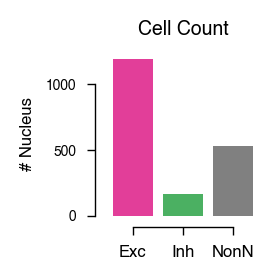

In [24]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=200)
sns.histplot(
    x="valence",
    hue="valence",
    palette=pal,
    data=col_df,
    legend=False,
    alpha=1,
    shrink=0.8,
    edgecolor="w",
    linewidth=0,
    hue_order=pal,
)

sns.despine(ax=ax, offset=4, trim=True)
ax.set_ylabel("# Nucleus", fontdict=font_small)
_ = ax.set_xlabel(None, fontdict=font_small)
# _ = ax.set_xticks(range(len(pal)))
# _ = ax.set_xticklabels([class_label[k] for k in pal])

ax.tick_params(width=0.5, length=3)

ax.yaxis.set_tick_params(labelsize=labelsize_small)
ax.xaxis.set_tick_params(labelsize=labelsize_large)
_ = ax.set_title("Cell Count", fontdict=font_big)

plt.tight_layout()
if save_figures:
    fig.savefig(f"{plot_dir}/simple_cell_count.pdf", bbox_inches="tight")

In [26]:
glia_order = np.array(glia_df.groupby('cell_type').agg({'valid': 'count'}).sort_values(by='valid', ascending=False).index)

glia_df['cell_type'] = glia_df['cell_type'].astype(pd.CategoricalDtype(categories=glia_order, ordered=True))

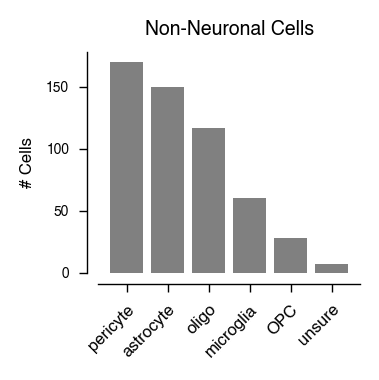

In [27]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=200)
sns.histplot(
    x="cell_type",
    hue="valence",
    palette=pal,
    data=glia_df,
    legend=False,
    alpha=1,
    shrink=0.8,
    edgecolor="w",
    linewidth=0,
    hue_order=pal,
)

sns.despine(ax=ax, offset=4)
ax.set_ylabel("# Cells", fontdict=font_small)
_ = ax.set_xlabel(None, fontdict=font_small)
_ = ax.set_xticks(range(len(glia_order)))
_ = ax.set_xticklabels(
    glia_order, fontdict=font_small, rotation=45, rotation_mode="anchor", ha="right"
)

ax.tick_params(width=0.5, length=3)
ax.yaxis.set_tick_params(labelsize=labelsize_small)
_ = ax.set_title('Non-Neuronal Cells', fontdict=font_big)

plt.tight_layout()
if save_figures:
    fig.savefig(f"{plot_dir}/nonneuronal_cell_count.pdf", bbox_inches="tight")

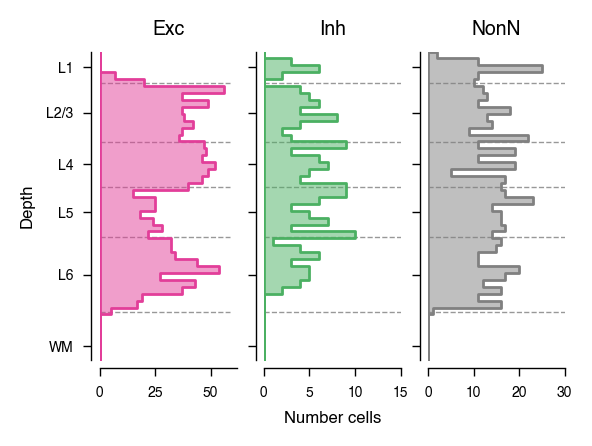

In [28]:
fig, axes = plt.subplots(figsize=(3, 2), ncols=3, dpi=200, sharey=True)

for ax, cs in zip(axes, pal):
    sns.histplot(
        y="soma_depth",
        hue="valence",
        palette=pal,
        data=col_df.query("valence== @cs"),
        ax=ax,
        legend=False,
        bins=bins,
        element="step",
        stat="count",
        linewidth=1,
        alpha=0.5,
        zorder=10,
    )

    ax.xaxis.set_tick_params(labelsize=labelsize_small)
    ax.set_title(cs, fontdict=font_big)
    ax.tick_params(width=0.5, length=3)
    sns.despine(ax=ax, offset=3)

axes[0].set_xlabel("")
axes[0].set_ylabel("Depth", fontdict=font_med)
axes[2].set_xlabel("")

axes[1].set_xlim(0,15)
axes[2].set_xlim(0,30)
axes[0].yaxis.set_tick_params(labelsize=labelsize_small)

axes[1].set_xlabel('Number cells', fontdict=font_med)

for ax in axes:
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        span=ax.get_xlim(),
        ax=ax,
        color=(0.2, 0.2, 0.2),
        linestyle="--",
        linewidth=0.5,
        alpha=0.5,
        zorder=-10,
    )
    
ax.set_ylim(height_bounds[1]-60, height_bounds[0])

if save_figures:
    fig.savefig(f"{plot_dir}/soma_depth_distribution.pdf", bbox_inches="tight")

In [41]:
nrn_oids = col_df.query('classification_system != "aibs_coarse_nonneuronal"')['pt_root_id']

In [42]:
col_syn_df = pd.read_feather(
    f"{project_paths.data}/temp/baseline_synapses_{environ}_v{version}_post.feather"
)

In [43]:
col_syn_df['syn_depth_um'] = tform.apply_project('y', col_syn_df['ctr_pt_position'])

In [44]:
#Removing non-soma/non-dendrite synaptic inputs
col_syn_df_dend = col_syn_df.query('is_dendrite').reset_index(drop=True)

In [45]:
syn_bins = np.arange(col_syn_df_dend['syn_depth_um'].min(), col_syn_df_dend['syn_depth_um'].max(), 5)

In [46]:
divide_by_million = partial(divide_by_number, number=1_000_000)

In [48]:
um_per_bin = (20 * 100 * 100) # microns^3
um_per_mm = (1000 * 1000 * 1000) # microns^3 / mm^3

In [56]:
col_syn_df['syn_bin'] = pd.cut(col_syn_df['syn_depth_um'], syn_bins)

In [60]:
col_syn_df.query('valence=="Exc"').groupby('syn_bin').count()[['id']].to_clipboard()

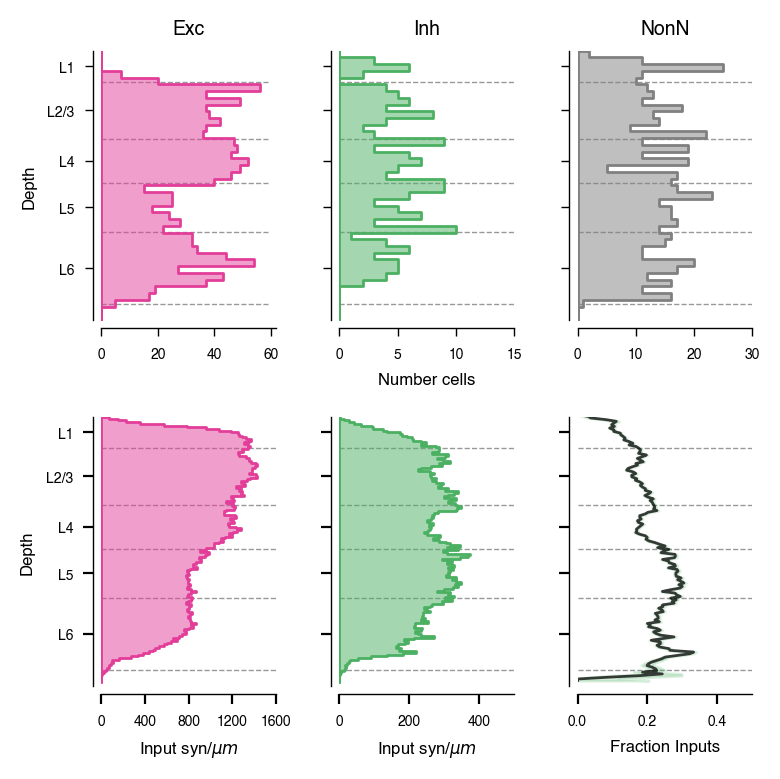

In [36]:
divide_by_syn_bin = partial(divide_by_number_int, number=np.diff(syn_bins).mean())

from statsmodels.stats import proportion

exc_hist, _ = np.histogram(
    col_syn_df.query('valence == "Exc"')["syn_depth_um"], bins=syn_bins
)
inh_hist, _ = np.histogram(
    col_syn_df.query('valence == "Inh"')["syn_depth_um"], bins=syn_bins
)

lb, ub = proportion.proportion_confint(inh_hist, exc_hist + inh_hist, method="wilson")

fig, axes = plt.subplots(figsize=(4, 4), facecolor="w", nrows=2, ncols=3, sharey=True, dpi=200)

for ax, cs in zip(axes[0,:], pal):
    sns.histplot(
        y="soma_depth",
        hue="valence",
        palette=pal,
        data=col_df.query("valence== @cs"),
        ax=ax,
        legend=False,
        bins=bins,
        element="step",
        stat="count",
        linewidth=1,
        alpha=0.5,
        zorder=10,
    )

    ax.xaxis.set_tick_params(labelsize=labelsize_small)
    ax.set_title(cs, fontdict=font_big)
    ax.tick_params(width=0.5, length=3)
    sns.despine(ax=ax, offset=3)

axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("Depth", fontdict=font_med)
axes[0,2].set_xlabel("")

axes[0,1].set_xlim(0,15)
axes[0,2].set_xlim(0,30)
axes[0,0].yaxis.set_tick_params(labelsize=labelsize_small)

axes[0,1].set_xlabel('Number cells', fontdict=font_med)

for ax in axes[0,:]:
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        span=ax.get_xlim(),
        ax=ax,
        color=(0.2, 0.2, 0.2),
        linestyle="--",
        linewidth=0.5,
        alpha=0.5,
        zorder=-10,
    )
    
# ax.set_ylim(height_bounds[1]-60, height_bounds[0])


ax = axes[1,0]
sns.histplot(
    y="syn_depth_um",
    hue="valence",
    element="step",
    fill=True,
    stat="frequency",
    hue_order=["Inh", "Exc"],
    palette={"Exc": vis_config.e_color, "Inh": vis_config.i_color},
    bins=syn_bins,
    data=col_syn_df.query('valence == "Exc"'),
    ax=ax,
    legend=False,
    alpha=0.5,
    linewidth=1,
)

ax.set_xlim((0, 8000))
ax.set_xticks([0, 2_000, 4_000, 6_000, 8_000])
sns.despine(ax=ax)

ax = axes[1,1]
sns.histplot(
    y="syn_depth_um",
    hue="valence",
    element="step",
    stat="frequency",
    fill=True,
    hue_order=["Inh", "Exc"],
    palette={"Exc": vis_config.e_color, "Inh": vis_config.i_color},
    bins=syn_bins,
    data=col_syn_df.query('valence == "Inh"'),
    ax=ax,
    legend=False,
    alpha=0.5,
    linewidth=1,
)

ax.set_xlim((0, 2_500))
ax.set_xticks([0, 1_000, 2_000])
sns.despine(ax=ax)

ax = axes[1,2]
ax.fill_betweenx(
    syn_bins[0:-1] + np.diff(syn_bins)[0] / 2,
    lb,
    ub,
    color=vis_config.i_color,
    alpha=0.2,
)
ax.plot(
    inh_hist / (exc_hist + inh_hist),
    syn_bins[0:-1] + np.diff(syn_bins)[0] / 2,
    color="k",
    linewidth=1,
    alpha=0.75,
)
ax.set_xlim(0, 0.5)

# plot_layer_bounds(ax)
# axes[0].invert_yaxis()
# axes[1,0].set_title("Exc.", fontdict=font_big)
axes[1,0].xaxis.set_major_formatter(partial(divide_by_number_int, number=5))
axes[1,0].set_xlabel('Input syn/$\mu m$', fontdict=font_med)

# axes[1,1].set_title("Inh.", fontdict=font_big)
axes[1,1].xaxis.set_major_formatter(partial(divide_by_number_int, number=5))
axes[1,1].set_xlabel('Input syn/$\mu m$', fontdict=font_med)

# axes[1,2].set_title("Inh. / (Inh + Exc)", fontdict=font_big)
axes[1,2].set_xlabel("Fraction Inputs", fontdict=font_med)

axes[1,0].set_ylabel("Depth", fontdict=font_med)
axes[1,0].yaxis.set_tick_params(labelsize=labelsize_small)

for ax in axes[1,:]:
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        span=ax.get_xlim(),
        ax=ax,
        color=(0.2, 0.2, 0.2),
        linestyle="--",
        linewidth=0.5,
        alpha=0.5,
        zorder=-10,
    )
    ax.xaxis.set_tick_params(labelsize=labelsize_small)
    sns.despine(ax=ax, offset=3)
    
ax.set_ylim(height_bounds[1]-150, height_bounds[0])
plt.tight_layout()

if save_figures:
    fig.savefig(f"{plot_dir}/synapse_depth_distribution_histogram.pdf", bbox_inches="tight")

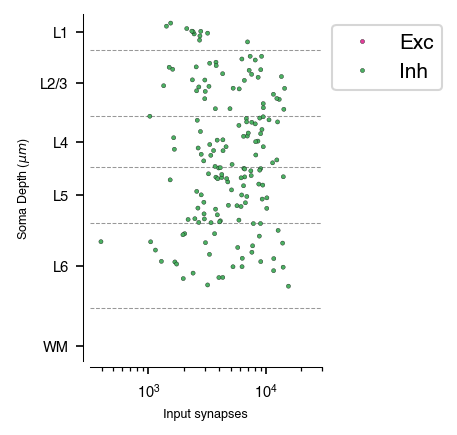

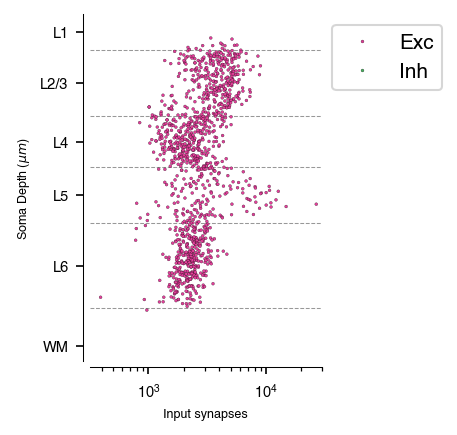

In [52]:
fig, ax = plt.subplots(figsize=(2,3), dpi=150)
sns.scatterplot(
    x='num_input',
    y='soma_depth',
    hue='valence',
    hue_order=["Exc", "Inh"],
    palette={"Exc": vis_config.e_color, "Inh": vis_config.i_color},
    data=ct_df.query('valence=="Inh"'),
    s=4,
    alpha=1,
    ec='k',
    # edgecolor=(0.3, 0.3, 0.3),
)

ax.set_xscale('log')
ax.legend().set_bbox_to_anchor((1,1))
sns.despine(ax=ax,offset=3)
ax.set_xlabel('Input synapses', fontdict=font_med)
ax.set_ylabel('Soma Depth ($\mu m$)', fontdict=font_med)
ax.yaxis.set_tick_params(labelsize=labelsize_med)
ax.xaxis.set_tick_params(labelsize=labelsize_med)
ax.set_xlim(315, 30000)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=ax.get_xlim(),
    ax=ax,
    color=(0.2, 0.2, 0.2),
    linestyle="--",
    linewidth=0.5,
    alpha=0.5,
    zorder=-10,
)
ax.set_ylim(height_bounds[1]-60, height_bounds[0])

if save_figures:
    fig.savefig(f"{plot_dir}/synapse_depth_distribution_inh.pdf", bbox_inches="tight")
    
fig, ax = plt.subplots(figsize=(2,3), dpi=150)
sns.scatterplot(
    x='num_input',
    y='soma_depth',
    hue='valence',
    hue_order=["Exc", "Inh"],
    palette={"Exc": vis_config.e_color, "Inh": vis_config.i_color},
    data=ct_df.query('valence=="Exc"'),
    s=2,
    alpha=1,
    ec='k',
    # edgecolor=(0.3, 0.3, 0.3),
)


ax.set_xscale('log')
ax.legend().set_bbox_to_anchor((1,1))
sns.despine(ax=ax,offset=3)
ax.set_xlabel('Input synapses', fontdict=font_med)
ax.set_ylabel('Soma Depth ($\mu m$)', fontdict=font_med)
ax.yaxis.set_tick_params(labelsize=labelsize_med)
ax.xaxis.set_tick_params(labelsize=labelsize_med)
ax.set_xlim(315, 30000)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=ax.get_xlim(),
    ax=ax,
    color=(0.2, 0.2, 0.2),
    linestyle="--",
    linewidth=0.5,
    alpha=0.5,
    zorder=-10,
)
ax.set_ylim(height_bounds[1]-60, height_bounds[0])


if save_figures:
    fig.savefig(f"{plot_dir}/synapse_depth_distribution_exc.pdf", bbox_inches="tight")

In [72]:
ct_df.query('valence=="Inh"')[['soma_depth', 'num_input', 'num_out']].sort_values(by=['soma_depth']).to_clipboard()

In [66]:
ct_df['num_out'] = pre_df_all.groupby('pre_pt_root_id').count()['id']

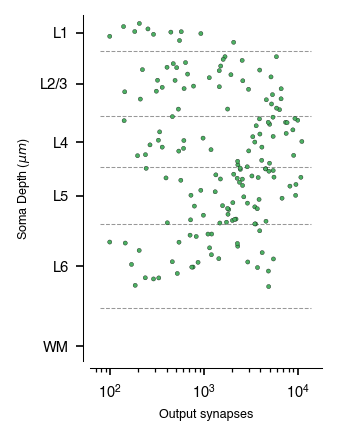

In [54]:
fig, ax = plt.subplots(figsize=(2,3), dpi=150)
sns.scatterplot(
    x='num_out',
    y='soma_depth',
    hue='valence',
    hue_order=["Exc", "Inh"],
    palette={"Exc": vis_config.e_color, "Inh": vis_config.i_color},
    data=ct_df.query('valence=="Inh"'),
    s=4,
    alpha=1,
    ec='k',
    legend=False,
)

ax.set_xscale('log')
sns.despine(ax=ax,offset=3)
ax.set_xlabel('Output synapses', fontdict=font_med)
ax.set_ylabel('Soma Depth ($\mu m$)', fontdict=font_med)
ax.yaxis.set_tick_params(labelsize=labelsize_med)
ax.xaxis.set_tick_params(labelsize=labelsize_med)
ax.set_ylim(height_bounds[1]-60, height_bounds[0])

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    span=ax.get_xlim(),
    ax=ax,
    color=(0.2, 0.2, 0.2),
    linestyle="--",
    linewidth=0.5,
    alpha=0.5,
    zorder=-10,
)
ax.set_ylim(height_bounds[1]-60, height_bounds[0])

if save_figures:
    fig.savefig(f"{plot_dir}/synapse_depth_distribution_inh_output.pdf", bbox_inches="tight")